#### 사용 데이터: backpain_28639사용_결측처리(모두MICE).csv    
#### full 변수에 대해서 한 번에 ML 분석       
#### 클래스 불균형 처리: RandomOverSampler(random_state=42) 사용      
####- RandomizedSearchCV  : 속도빠르게 하기 위함
- cv=5, scoring='roc_auc', n_iter=4  
- n_jobs=-1로 병렬 처리 (속도 향상)  
- random_state=42로 재현성 확보



In [ ]:
!pip install catboost lightgbm xgboost imbalanced-learn scikit-learn tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    roc_curve, auc
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import RandomOverSampler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/UKBB 분석')


data = pd.read_csv("backpain_28639사용_결측처리(모두MICE).csv")
data.columns = data.columns.str.strip()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(">>>> 데이터 로드 완료:", data.shape)
display(data.head())
data.info()

>>>> 데이터 로드 완료: (189401, 17)


,sex,ethnicity,education,income,occupation,social_activity,social_contacts_frequency,household_size,moderate_exercise_frequency,alcohol_frequency,sleep_hours,fatigue_frequency,feeling_depressed,feeling_anxious,low_back_pain,age,participant_id
0,0,0,2,3,0,1,4,1,2,3,7.29,1,0,0,1,84.0,1000020
1,1,0,0,1,0,1,4,1,2,2,7.17,1,0,0,0,80.0,1000199
2,0,0,2,1,0,1,4,1,1,2,8.00,4,2,2,1,76.0,1000894
3,1,0,2,1,0,1,4,1,0,3,7.00,1,0,0,1,82.0,1000925
4,0,0,4,2,1,1,3,1,2,3,7.32,1,0,0,0,60.0,1001066


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189401 entries, 0 to 189400
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   sex                          189401 non-null  int64  
 1   ethnicity                    189401 non-null  int64  
 2   education                    189401 non-null  int64  
 3   income                       189401 non-null  int64  
 4   occupation                   189401 non-null  int64  
 5   social_activity              189401 non-null  int64  
 6   social_contacts_frequency    189401 non-null  int64  
 7   household_size               189401 non-null  int64  
 8   moderate_exercise_frequency  189401 non-null  int64  
 9   alcohol_frequency            189401 non-null  int64  
 10  sleep_hours                  189401 non-null  float64
 11  fatigue_frequency            189401 non-null  int64  
 12  feeling_depressed            189401 non-null  int64  
 13 

In [ ]:
print("\n>>>> 타겟 분포")
print(data['low_back_pain'].value_counts())


>>>> 타겟 분포
low_back_pain
0    142479
1     46922
Name: count, dtype: int64


In [ ]:
# 독립, 종속 변수 분리
X = data.drop(columns=["low_back_pain", "participant_id"])
y = data["low_back_pain"]

categorical_cols = [
    'sex', 'ethnicity', 'education', 'income', 'occupation',
    'social_activity', 'social_contacts_frequency', 'household_size',
    'moderate_exercise_frequency', 'alcohol_frequency',
    'fatigue_frequency', 'feeling_depressed', 'feeling_anxious'
]
continuous_cols = ['sleep_hours', 'age']

In [ ]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [ ]:
# RandomOverSampler로 불균형 보정
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# 연속형 변수 스케일링
scaler = MinMaxScaler()
X_train_res[continuous_cols] = scaler.fit_transform(X_train_res[continuous_cols])
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

In [ ]:
models_params = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, solver='liblinear', random_state=2023),
     {"C": [0.1, 1, 10]}),

    ("Random Forest", RandomForestClassifier(random_state=2023, n_jobs=-1),
     {"n_estimators": [100, 200], "max_depth": [5, 10, None], "min_samples_split": [2, 5]}),

    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=2023, n_jobs=-1),
     {"n_estimators": [100, 200], "max_depth": [3, 5, 7], "learning_rate": [0.05, 0.1]}),

    ("LightGBM", LGBMClassifier(random_state=2023, n_jobs=-1),
     {"n_estimators": [100, 200], "max_depth": [-1, 5, 10], "learning_rate": [0.05, 0.1]}),

    ("CatBoost", CatBoostClassifier(verbose=0, random_state=2023),
     {"n_estimators": [100, 200], "max_depth": [5, 7], "learning_rate": [0.05, 0.1]})
]

In [ ]:
best_models = {}
metrics = []

for name, model, params in tqdm(models_params, desc="모델 학습 진행 중"):
    print(f"\n● {name} 학습 중...")
    grid = RandomizedSearchCV(model, params, cv=5, n_iter=4, scoring='roc_auc', n_jobs=-1, random_state=42)
    grid.fit(X_train_res, y_train_res)
    best_models[name] = grid.best_estimator_

    y_pred = grid.predict(X_test)
    y_prob = grid.predict_proba(X_test)[:, 1]

    metrics.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_test, y_pred), 3),
        "Precision": round(precision_score(y_test, y_pred), 3),
        "Recall": round(recall_score(y_test, y_pred), 3),
        "F1": round(f1_score(y_test, y_pred), 3),
        "AUROC": round(roc_auc_score(y_test, y_prob), 3),
        "PR-AUC": round(average_precision_score(y_test, y_prob), 3),
        "Balanced Accuracy": round(balanced_accuracy_score(y_test, y_pred), 3)
    })
    print(f">> 완료 | Best Params: {grid.best_params_}")

results_df = pd.DataFrame(metrics).sort_values("AUROC", ascending=False)
display(results_df)

모델 학습 진행 중:   0%|          | 0/5 [00:00<?, ?it/s]


● Logistic Regression 학습 중...


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=4. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
모델 학습 진행 중:  20%|██        | 1/5 [00:24<01:36, 24.14s/it]

>> 완료 | Best Params: {'C': 0.1}

● Random Forest 학습 중...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
모델 학습 진행 중:  40%|████      | 2/5 [09:27<16:28, 329.42s/it]

>> 완료 | Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None}

● XGBoost 학습 중...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:44:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
모델 학습 진행 중:  60%|██████    | 3/5 [10:10<06:37, 198.96s/it]

>> 완료 | Best Params: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}

● LightGBM 학습 중...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Number of positive: 99735, number of negative: 99735
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 199470, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

모델 학습 진행 중:  80%|████████  | 4/5 [12:31<02:55, 175.82s/it]

>> 완료 | Best Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}

● CatBoost 학습 중...


모델 학습 진행 중: 100%|██████████| 5/5 [15:29<00:00, 185.90s/it]

>> 완료 | Best Params: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1}


,Model,Accuracy,Precision,Recall,F1,AUROC,PR-AUC,Balanced Accuracy
4,CatBoost,0.694,0.423,0.644,0.511,0.759,0.578,0.677
3,LightGBM,0.691,0.420,0.646,0.509,0.756,0.570,0.676
2,XGBoost,0.696,0.424,0.637,0.510,0.756,0.574,0.676
1,Random Forest,0.762,0.530,0.368,0.434,0.725,0.511,0.630
0,Logistic Regression,0.650,0.366,0.563,0.444,0.668,0.402,0.621


In [ ]:
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, balanced_accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
# 신뢰구간 계산 함수 정의
def calculate_confidence_interval(metric, n, alpha=0.05):
    """단순 normal-approximation 기반 95% CI 계산"""
    return proportion_confint(metric * n, n, alpha=alpha, method='normal')

# 모델별 성능 및 신뢰구간 계산
metrics_ci = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUROC', 'PR-AUC', 'Balanced Accuracy']
results_ci = {metric: [] for metric in metrics_ci}
confidence_intervals = {metric: [] for metric in metrics_ci}

print("\n=== 모델별 성능 및 95% 신뢰구간 ===")

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    results_ci['Accuracy'].append(round(accuracy, 3))
    results_ci['Precision'].append(round(precision, 3))
    results_ci['Recall'].append(round(recall, 3))
    results_ci['F1'].append(round(f1, 3))
    results_ci['AUROC'].append(round(auroc, 3))
    results_ci['PR-AUC'].append(round(pr_auc, 3))
    results_ci['Balanced Accuracy'].append(round(balanced_acc, 3))

    n = len(y_test)
    confidence_intervals['Accuracy'].append(tuple(map(lambda x: round(x, 3), calculate_confidence_interval(accuracy, n))))
    confidence_intervals['Precision'].append(tuple(map(lambda x: round(x, 3), calculate_confidence_interval(precision, n))))
    confidence_intervals['Recall'].append(tuple(map(lambda x: round(x, 3), calculate_confidence_interval(recall, n))))
    confidence_intervals['AUROC'].append(tuple(map(lambda x: round(x, 3), calculate_confidence_interval(auroc, n))))

# 결과
ci_df = pd.DataFrame(results_ci, index=list(best_models.keys())).sort_values("AUROC", ascending=False)
print("\n=== 모델별 성능 요약 (AUROC 기준 내림차순) ===")
display(ci_df)

print("\n=== 95% Confidence Intervals by Metric ===")
for metric in confidence_intervals.keys():
    print(f"\n📏 {metric} 95% CI:")
    for model_name, interval in zip(list(best_models.keys()), confidence_intervals[metric]):
        print(f"{model_name}: {interval}")


=== 모델별 성능 및 95% 신뢰구간 ===

=== 모델별 성능 요약 (AUROC 기준 내림차순) ===


,Accuracy,Precision,Recall,F1,AUROC,PR-AUC,Balanced Accuracy
CatBoost,0.694,0.423,0.644,0.511,0.759,0.578,0.677
LightGBM,0.691,0.420,0.646,0.509,0.756,0.570,0.676
XGBoost,0.696,0.424,0.637,0.510,0.756,0.574,0.676
Random Forest,0.762,0.530,0.368,0.434,0.725,0.511,0.630
Logistic Regression,0.650,0.366,0.563,0.444,0.668,0.402,0.621



=== 95% Confidence Intervals by Metric ===

📏 Accuracy 95% CI:
Logistic Regression: (0.646, 0.654)
Random Forest: (0.759, 0.766)
XGBoost: (0.692, 0.7)
LightGBM: (0.687, 0.695)
CatBoost: (0.69, 0.698)

📏 Precision 95% CI:
Logistic Regression: (0.362, 0.37)
Random Forest: (0.526, 0.534)
XGBoost: (0.42, 0.429)
LightGBM: (0.416, 0.424)
CatBoost: (0.419, 0.427)

📏 Recall 95% CI:
Logistic Regression: (0.559, 0.567)
Random Forest: (0.364, 0.372)
XGBoost: (0.633, 0.641)
LightGBM: (0.642, 0.65)
CatBoost: (0.64, 0.648)

📏 F1 95% CI:

📏 AUROC 95% CI:
Logistic Regression: (0.664, 0.672)
Random Forest: (0.722, 0.729)
XGBoost: (0.752, 0.759)
LightGBM: (0.752, 0.759)
CatBoost: (0.756, 0.763)

📏 PR-AUC 95% CI:

📏 Balanced Accuracy 95% CI:


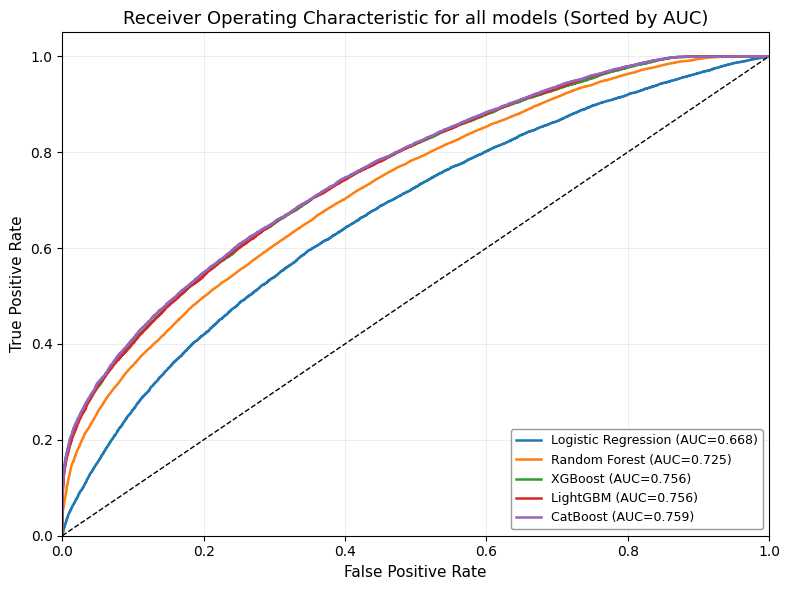

In [ ]:
plt.figure(figsize=(8, 6))

custom_colors = [
    '#1f77b4',  # 파랑 (Logistic Regression)
    '#ff7f0e',  # 주황 (Random Forest)
    '#2ca02c',  # 초록 (XGBoost)
    '#d62728',  # 빨강 (LightGBM)
    '#9467bd',  # 보라 (CatBoost)
]

# 모델 이름 순서에 맞게 색상 반복 적용
for (name, model), color in zip(best_models.items(), custom_colors):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr, tpr,
        color=color,
        lw=1.8,
        label=f'{name} (AUC={roc_auc:.3f})'
    )

# 대각선 기준선
plt.plot([0, 1], [0, 1], 'k--', lw=1)

# 제목 및 축 라벨
plt.title("Receiver Operating Characteristic for all models (Sorted by AUC)", fontsize=13)
plt.xlabel("False Positive Rate", fontsize=11)
plt.ylabel("True Positive Rate", fontsize=11)

# 실선 격자 (그래프 내부)
plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.3)

# 축 맞춤: X축은 정확히 끝까지, Y축은 여유 있게
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.05)   # ✅ 위쪽 살짝 여유(5% 정도)

# 범례: 그래프 내부 오른쪽 아래 + 옅은 테두리
plt.legend(
    loc='lower right',
    fancybox=True,
    frameon=True,
    facecolor='white',
    edgecolor='#999999',   # 옅은 회색 테두리
    framealpha=1.0,
    fontsize=9
)

plt.tight_layout()
plt.show()